# Workshop 4: Tool Design for Data Analysis Agents

**Today's Goal:** Start building an AI-powered Analytics Agent

**What we'll be doing:**
- Introduce dataset
- Design thinking exercise
- Build 9 well-designed data analysis tools (exploration + analysis + visualization)
- A simple ReAct agent

**Why this matters:** Tool design is the foundation of effective agents. Tool design makes or breaks AI Agents.

## Part 0: Setup & Dataset Introduction

In [1]:
!./download_dataset.sh

Pokemon dataset already exists. Skipping download and extraction.


In [2]:
# Imports
import pandas as pd
import os
from openai import OpenAI
import matplotlib.pyplot as plt
from pydantic import BaseModel
from typing import Optional, Type, Union

# Initialize our OpenAI client
openai_client = OpenAI()

def generate(
    prompt: str,
    temperature: float = 0,
    response_format: Optional[Type[BaseModel]] = None,
    model: str = "gpt-4o-mini"
) -> Union[str, BaseModel]:
    """
    Generate text using OpenAI's API with optional structured output
    
    Args:
        prompt: The input prompt for generation
        temperature: Sampling temperature (0-2), default 0.7
        response_format: Optional Pydantic model class for structured output
        model: The model to use, default "gpt-4o-mini"
    
    Returns:
        Either a string (regular generation) or a Pydantic model instance (structured output)
    """
    messages = [
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": prompt}
    ]
    
    if response_format is not None:
        # Use structured output with Pydantic model
        response = openai_client.beta.chat.completions.parse(
            model=model,
            messages=messages,
            temperature=temperature,
            response_format=response_format
        )
        return response.choices[0].message.parsed
    else:
        # Regular text generation
        response = openai_client.chat.completions.create(
            model=model,
            messages=messages,
            temperature=temperature
        )
        return response.choices[0].message.content.strip()

### Our Dataset: Pokemon with stats ([Kaggle](https://www.kaggle.com/datasets/abcsds/pokemon)) 


We're using Pokemon data for this workshop because:
1. **Universally familiar** - most people (I hope) know what they are and understand the doman somewhat 
2. **Simple domain** - simple and intuitive data, lets us focus 100% on principles of tool design, not domain complexity
3. **Rich enough** - has categorical (type), numerical (stats), and boolean (legendary) data

**The patterns we'll explore today should work identically with customer data, medical records, financial data, etc.** We're using Pokemon as a way to keep the workshop focused on the Agent design parts, but you're encouraged to apply these patterns to your own datasets.

Let's explore the data:

In [3]:
# Load Pokemon dataset
df = pd.read_csv('data/Pokemon.csv')
df.columns = (df.columns
              .str.replace(' ', '_', regex=False)
              .str.replace('.', '', regex=False)
              .str.lower()
             )

print(f"Dataset: {df.shape[0]} Pokemon, {df.shape[1]} columns")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst few rows:")
df.head()

Dataset: 800 Pokemon, 13 columns

Columns: ['#', 'name', 'type_1', 'type_2', 'total', 'hp', 'attack', 'defense', 'sp_atk', 'sp_def', 'speed', 'generation', 'legendary']

First few rows:


,#,name,type_1,type_2,total,hp,attack,defense,sp_atk,sp_def,speed,generation,legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


In [4]:
# Quick look at data types and stats
print("Data types:")
print(df.dtypes)
print("\nBasic statistics:")
df.describe()

Data types:
#              int64
name          object
type_1        object
type_2        object
total          int64
hp             int64
attack         int64
defense        int64
sp_atk         int64
sp_def         int64
speed          int64
generation     int64
legendary       bool
dtype: object

Basic statistics:


,#,total,hp,attack,defense,sp_atk,sp_def,speed,generation
count,800.000000,800.00000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.00000
mean,362.813750,435.10250,69.258750,79.001250,73.842500,72.820000,71.902500,68.277500,3.32375
std,208.343798,119.96304,25.534669,32.457366,31.183501,32.722294,27.828916,29.060474,1.66129
min,1.000000,180.00000,1.000000,5.000000,5.000000,10.000000,20.000000,5.000000,1.00000
25%,184.750000,330.00000,50.000000,55.000000,50.000000,49.750000,50.000000,45.000000,2.00000
50%,364.500000,450.00000,65.000000,75.000000,70.000000,65.000000,70.000000,65.000000,3.00000
75%,539.250000,515.00000,80.000000,100.000000,90.000000,95.000000,90.000000,90.000000,5.00000
max,721.000000,780.00000,255.000000,190.000000,230.000000,194.000000,230.000000,180.000000,6.00000


**Dataset Columns**

| Column Name | Description |
|-------------|-------------|
| `#` | ID for each pokemon |
| `name` | Name of each pokemon |
| `type_1` | Each pokemon has a type, this determines weakness/resistance to attacks |
| `type_2` | Some pokemon are dual type and have 2 (for eg. Bulbasaur is Grass & Poison)|
| `total` | Sum of all stats that come after this, a general guide to how strong a pokemon is |
| `hp` | Hit points, or health, defines how much damage a pokemon can withstand before fainting |
| `attack` | The base modifier for normal attacks (eg. Scratch, Punch) |
| `defense` | The base damage resistance against normal attacks |
| `sp_atk` | Special attack, the base modifier for special attacks (e.g. fire blast, bubble beam) |
| `sp_def` | The base damage resistance against special attacks |
| `speed` | Determines which pokemon attacks first each round |

### Quick Context: Where Are We?

**Last Workshop (W3):** We built a simple ReAct agent for the ER wait time system. It worked to some extent, but was a more contrived scenario. Today we will start building our analytics agent on a dataset of our choice, and enable it to load the dataset, and perform some actions on the data.

---

## Part 1: Designing Tools

Before writing any code, we need to think through: 

- **What do we want to build?**

  A data analysis agent that can answer questions about our dataset in natural language.
  
- **What capabilities does the agent need?**
- **What tools do we actually need?**

### Step 1: What Queries Should Our Agent Handle?

  Let's start some potential user queries that our agent should generally be able to handle:

  1. "Show me the first 10 Pokemon"
  2. "Show me all Fire type Pokemon"
  3. "Show me Pokemon with Attack > 100"
  4. "What's the average HP of all Pokemon?"
  5. "Show me the average Attack by type"
  6. "Which type has the highest average Speed?"
  7. "Show me legendary Fire types"
  8. "How many Pokemon per generation?"
  9. "Compare legendary vs non-legendary average stats"
  10. "Show me the strongest Pokemon overall"
  11. "Create a bar chart of Pokemon count by type"
  12. "Plot the relationship between Attack and Defense"
  13. "Show me a histogram of HP distribution"

  **Question:** How many tools do we need?

  **First instinct:** 13 tools? One per query?

  **Problem:** Users could ask **infinite** questions. We can't build infinite tools.

  **Solution:** Find the underlying **patterns**.

  Better with visualization queries included?

### Step 2: Find the Capabilities

  Let's analyze what CAPABILITY each query actually needs:

  **EXPLORATION (see the data):**
  - "Show me first 10 Pokemon" → VIEW data
  - "Show info about dataset" → INSPECT structure

  **FILTERING (select subsets):**
  - "Fire type Pokemon" → Filter where `type1 == 'Fire'`
  - "Attack > 100" → Filter where `attack > 100`
  - "Legendary Fire types" → Filter where `type1 == 'Fire' AND legendary == True`

  **ANALYSIS (compute stats):**
  - "Average HP" → `mean(hp)`
  - "Max Attack by type" → `group_by(type1).max(attack)`
  - "Count per generation" → `group_by(generation).count()`

  **VISUALIZATION (show patterns):**
  - "Bar chart of Pokemon count by type" → Bar chart with categories
  - "Attack vs Defense relationship" → Scatter plot
  - "HP distribution" → Histogram

  ---

  **The Key Insight:** 13 queries → 4 core capabilities

### Step 3: Tool Granularity - (Critical Design Decision)

Now we know the capabilities. But to enable our agent to have those capabilities, we need to build tools that enable those capabilities.

Here lies a very crucial design decision: **granularity**.

Let's explore some different approaches to building a filtering tool and think through which might work the best.

#### Design A: Very Broad Tool
One potential tool could be something that can do a lot of things, from filtering data, to aggregating them, displaying them, etc.

```python
def analyze_data(operation: str, **params):
    """Analyze the data somehow.
    
    Args:
        operation: Type of operation (filter, aggregate, etc.)
        **params: Various parameters depending on operation
    """
    # Implementation would go here
    pass
```

**Let's think:** Can an LLM use this effectively?

In [5]:
# Test Design A
test_prompt = """You have this tool:

analyze_data(operation: str, **params)
    Analyze the data somehow.
    Args:
        operation: Type of operation (filter, aggregate, etc.)
        **params: Various parameters depending on operation

Task: Show me all Fire type Pokemon

Respond with ONLY the function call, no explanation.
Format: analyze_data(...)
"""

response = generate(test_prompt)
print(f"LLM Response: {response}")

LLM Response: analyze_data("filter", type="Fire")


In [7]:
# Test Design A
test_prompt = """You have this tool:

analyze_data(operation: str, **params)
    Analyze the data somehow.
    Args:
        operation: Type of operation (filter, aggregate, etc.)
        **params: Various parameters depending on operation

Task: How many Pokemon per generation are there?

Respond with ONLY the function call, no explanation.
Format: analyze_data(...)
"""

response = generate(test_prompt)
print(f"LLM Response: {response}")

LLM Response: analyze_data("aggregate", type="pokemon", group_by="generation")


#### Design B: Very Specific Tools

```python
def get_fire_pokemon():
    """Get all Fire type Pokemon"""
    return df[df['Type 1'] == 'Fire']

def get_water_pokemon():
    """Get all Water type Pokemon"""
    return df[df['Type 1'] == 'Water']

def get_high_attack_pokemon():
    """Get Pokemon with attack > 100"""
    return df[df['Attack'] > 100]

# ... need separate function for every filter combination
```

**Let's test:** What happens when we ask for something slightly different?

In [8]:
# Test Design B
test_prompt = """You have these tools:

get_fire_pokemon()
    Get all Fire type Pokemon
    
get_water_pokemon()
    Get all Water type Pokemon
    
get_high_attack_pokemon()
    Get Pokemon with attack > 100

Task: Show me all Electric type Pokemon

What tool would you use for the given query? Respond with ONLY the function call, no explanation.
"""

response = generate(test_prompt)
print(f"LLM Response: {response}")

LLM Response: None


#### Design C: Composable Tool

```python
def filter_rows(condition: str):
    """Filter dataframe rows by condition.
    
    Args:
        condition: Pandas query string like:
            - "`Type 1` == 'Fire'"
            - "Attack > 100"
            - "`Type 1` == 'Fire' and Legendary == True"
    
    Returns:
        Filtered dataframe as string
    """
    return df.query(condition)
```

**Let's test:** Can this handle multiple different queries with ONE function?

In [9]:
# Test Design C with multiple queries
test_queries = [
    "Show me all Fire type Pokemon",
    "Show me all Electric type Pokemon",
    "Show me Pokemon with attack > 120",
    "Show me legendary Water types"
]

tool_description = """filter_rows(condition: str)
    Filter dataframe rows by condition.
    
    Args:
        condition: Pandas query string like:
            - "`Type 1` == 'Fire'"
            - "Attack > 100"
            - "`Type 1` == 'Fire' and Legendary == True"
"""

print("Testing Design C:\n")
for query in test_queries:
    prompt = f"""You have this tool:

{tool_description}

Dataset columns: #, Name, Type 1, Type 2, Total, HP, Attack, Defense, Sp. Atk, Sp. Def, Speed, Generation, Legendary

Task: {query}

Respond with ONLY the function call, no explanation.
Format: filter_rows(condition="...")
"""
    response = generate(prompt)
    print(f"Query: {query}")
    print(f"LLM Generated: {response}\n")

Testing Design C:

Query: Show me all Fire type Pokemon
LLM Generated: filter_rows(condition="`Type 1` == 'Fire'")

Query: Show me all Electric type Pokemon
LLM Generated: filter_rows(condition="`Type 1` == 'Electric'")

Query: Show me Pokemon with attack > 120
LLM Generated: filter_rows(condition="Attack > 120")

Query: Show me legendary Water types
LLM Generated: filter_rows(condition="`Type 1` == 'Water' and Legendary == True")



#### Takeaways?

**Design A (Too Broad):**
- Vague parameters (`**params`)
- LLM doesn't know what to pass
- Implementation would be messy with many conditionals
- **Problem:** Too many decisions, unclear contract

**Design B (Too Specific):**
- Clear what each function does
- But we'd need infinite functions for infinite queries
- `get_fire_pokemon()`, `get_water_pokemon()`, `get_electric_pokemon()`...
- What about `get_fast_fire_pokemon()`? `get_legendary_water_pokemon()`?
- **Problem:** Not scalable, combinatorial explosion

**Design C (Not too broad, not too specific):**
- Clear parameter contract (pandas query string)
- Examples in docstring guide LLM
- ONE function handles infinite filtering scenarios
- **Success:** Composable abstraction


### Our Final Tool Design

Here are the **9 tools** we'll build:

**EXPLORATION TOOLS:**
-  `load_csv(filepath)` - Load data into memory
-  `show_info()` - Show columns, types, missing values
-  `show_data(n=5, sort_by=None)` - Show first n rows, optionally sorted

**ANALYSIS TOOLS:**
-  `filter_rows(condition)` - Filter by any pandas query condition
-  `calculate_statistics(column, stat_type)` - Compute mean/max/min/count/etc
- `aggregate_by(group_by, agg_col, agg_func)` - Group and aggregate

**VISUALIZATION TOOLS:**
- `create_bar_chart(category_col, value_col, aggregation)` - Bar chart with aggregation
- `create_scatter_plot(x_col, y_col, color_by)` - Scatter plot for relationships
- `create_histogram(column, bins)` - Distribution of numerical data

Let's build them.

---

## Part 2: Building the Tools

We'll build each tool following these principles:
1. **Clear docstrings** - LLM reads these to understand the tool
2. **Examples in docstrings** - Show LLM how to use it
3. **Error handling** - Graceful failures with helpful messages
4. **Test individually** - Make sure each tool works before connecting to agent

In [10]:
# Global dataframe (keeping it simple for now, in production we'd refrain from using globals)
df = None

### Exploration Tools

In [11]:
def load_csv(filepath: str):
    """Load CSV file into global dataframe.
    
    Args:
        filepath: Path to CSV file
        
    Returns:
        Success message with shape
        
    Examples:
        load_csv('data/pokemon.csv')
        load_csv('data/sales.csv')
    """
    global df
    df = pd.read_csv(filepath)
    df.columns = (df.columns
      .str.replace(' ', '_', regex=False)
      .str.replace('.', '', regex=False)
      .str.lower()
    )
    return f"✓ Loaded file: {filepath} with {df.shape[0]} rows, {df.shape[1]} columns"


def show_info():
    """Show dataframe structure: columns, types, missing values.
    
    Returns:
        DataFrame info summary
    """
    if df is None:
        return "Error: No data loaded. Use load_csv() first."
    
    import io
    buffer = io.StringIO()
    df.info(buf=buffer)
    return buffer.getvalue()


def show_data(n: int = 5, sort_by: str = None, ascending: bool = True):
    """Show first n rows of dataframe, optionally sorted.
    
    Args:
        n: Number of rows to display
        sort_by: Optional column to sort by before showing
        ascending: Sort order if sort_by is specified
        
    Examples:
        show_data(10)  # Just show first 10
        show_data(10, sort_by="attack", ascending=False)  # Show top 10 by attack
    """
    display_df = df
    if sort_by:
        display_df = df.sort_values(sort_by, ascending=ascending)
    return display_df.head(n).to_string()

In [12]:
# Test exploration tools
print(load_csv('data/pokemon.csv'))

✓ Loaded file: data/pokemon.csv with 800 rows, 13 columns


In [13]:
print(show_info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   #           800 non-null    int64 
 1   name        800 non-null    object
 2   type_1      800 non-null    object
 3   type_2      414 non-null    object
 4   total       800 non-null    int64 
 5   hp          800 non-null    int64 
 6   attack      800 non-null    int64 
 7   defense     800 non-null    int64 
 8   sp_atk      800 non-null    int64 
 9   sp_def      800 non-null    int64 
 10  speed       800 non-null    int64 
 11  generation  800 non-null    int64 
 12  legendary   800 non-null    bool  
dtypes: bool(1), int64(9), object(3)
memory usage: 75.9+ KB



In [14]:
print(show_data(n=3, sort_by="type_1", ascending=True))

       #      name type_1 type_2  total  hp  attack  defense  sp_atk  sp_def  speed  generation  legendary
600  540  Sewaddle    Bug  Grass    310  45      53       70      40      60     42           5      False
136  127    Pinsir    Bug    NaN    500  65     125      100      55      70     85           1      False
457  412     Burmy    Bug    NaN    224  40      29       45      29      45     36           4      False


In [15]:
print(show_data(n=5, sort_by="type_2", ascending=False))

       #       name type_1 type_2  total  hp  attack  defense  sp_atk  sp_def  speed  generation  legendary
799  721  Volcanion   Fire  Water    600  80     110      120     130      90     70           6       True
152  141   Kabutops   Rock  Water    495  60     115      105      65      70     80           1      False
151  140     Kabuto   Rock  Water    355  30      80       90      55      45     55           1      False
150  139    Omastar   Rock  Water    495  70      60      125     115      70     55           1      False
149  138    Omanyte   Rock  Water    355  35      40      100      90      55     35           1      False


### Analysis Tools

In [16]:
def filter_rows(condition: str):
    """Filter dataframe rows using pandas query syntax.
    
    Args:
        condition: Pandas query string
        
    Returns:
        Filtered dataframe as string
        
    Examples:
        filter_rows("type_1 == 'Fire'")
        filter_rows("attack > 100")
        filter_rows("type_1 == 'Fire' and legendary == True")
        filter_rows("generation >= 3")
    """
    if df is None:
        return "Error: No data loaded. Use load_csv() first."
    
    try:
        result = df.query(condition)
        return f"Found {len(result)} Pokemon:\n{result.to_string()}"
    except Exception as e:
        return f"Error filtering: {str(e)}\nCheck your condition syntax."


def calculate_statistics(column: str, stat_type: str):
    """Calculate statistics on a column.
    
    Args:
        column: Column name to analyze
        stat_type: One of: 'mean', 'median', 'max', 'min', 'sum', 'count', 'std'
        
    Returns:
        Calculated statistic
        
    Examples:
        calculate_statistics('attack', 'mean')
        calculate_statistics('hp', 'max')
        calculate_statistics('speed', 'median')
    """
    if df is None:
        return "Error: No data loaded. Use load_csv() first."
    
    if column not in df.columns:
        return f"Error: Column '{column}' not found. Available: {df.columns.tolist()}"
    
    stat_functions = {
        'mean': df[column].mean,
        'median': df[column].median,
        'max': df[column].max,
        'min': df[column].min,
        'sum': df[column].sum,
        'count': df[column].count,
        'std': df[column].std
    }
    
    if stat_type not in stat_functions:
        return f"Error: Unknown stat '{stat_type}'. Choose from: {list(stat_functions.keys())}"
    
    try:
        result = stat_functions[stat_type]()
        return f"{stat_type.capitalize()} of {column}: {result:.2f}"
    except Exception as e:
        return f"Error: {str(e)}"


def aggregate_by(group_by: str, agg_col: str, agg_func: str):
    """Group data and calculate aggregate statistics.
    
    Args:
        group_by: Column to group by (e.g., 'type_1', 'generation')
        agg_col: Column to aggregate (e.g., 'attack', 'hp')
        agg_func: Aggregation function: 'mean', 'sum', 'count', 'max', 'min'
        
    Returns:
        Grouped results as string
        
    Examples:
        aggregate_by('type1', 'attack', 'mean')
        aggregate_by('generation', 'hp', 'max')
        aggregate_by('legendary', 'speed', 'mean')
    """
    if df is None:
        return "Error: No data loaded. Use load_csv() first."
    
    if group_by not in df.columns:
        return f"Error: Group column '{group_by}' not found."
    if agg_col not in df.columns:
        return f"Error: Aggregate column '{agg_col}' not found."
    
    valid_funcs = ['mean', 'sum', 'count', 'max', 'min']
    if agg_func not in valid_funcs:
        return f"Error: Unknown function '{agg_func}'. Choose from: {valid_funcs}"
    
    try:
        result = df.groupby(group_by)[agg_col].agg(agg_func)
        return f"{agg_func.capitalize()} of {agg_col} by {group_by}:\n{result.to_string()}"
    except Exception as e:
        return f"Error: {str(e)}"

In [17]:
# Test analysis tools
print(filter_rows("type_1 == 'Fire'"))

Found 52 Pokemon:
       #                       name type_1    type_2  total   hp  attack  defense  sp_atk  sp_def  speed  generation  legendary
4      4                 Charmander   Fire       NaN    309   39      52       43      60      50     65           1      False
5      5                 Charmeleon   Fire       NaN    405   58      64       58      80      65     80           1      False
6      6                  Charizard   Fire    Flying    534   78      84       78     109      85    100           1      False
7      6  CharizardMega Charizard X   Fire    Dragon    634   78     130      111     130      85    100           1      False
8      6  CharizardMega Charizard Y   Fire    Flying    634   78     104       78     159     115    100           1      False
42    37                     Vulpix   Fire       NaN    299   38      41       40      50      65     65           1      False
43    38                  Ninetales   Fire       NaN    505   73      76       75     

In [18]:
print(calculate_statistics('attack', 'mean'))

Mean of attack: 79.00


In [19]:
print(aggregate_by(group_by='type_1', agg_col='attack', agg_func='max'))

Max of attack by type_1:
type_1
Bug         185
Dark        150
Dragon      180
Electric    123
Fairy       131
Fighting    145
Fire        160
Flying      115
Ghost       165
Grass       132
Ground      180
Ice         130
Normal      160
Poison      106
Psychic     190
Rock        165
Steel       150
Water       155


In [21]:
def create_bar_chart(category_col: str, value_col: str = None, aggregation: str = 'count', title: str = None):
    """Create a bar chart comparing categories.

    Args:
        category_col: Column to group by (x-axis)
        value_col: Column to aggregate (y-axis). Not needed if aggregation='count'
        aggregation: 'count', 'mean', 'sum', 'max', 'min', 'median'
        title: Optional chart title

    Returns:
        Success message

    Examples:
        create_bar_chart('type_1')  # Count per type
        create_bar_chart('type_1', 'attack', 'mean')  # Avg attack per type
        create_bar_chart('generation', 'hp', 'max')  # Max HP per generation
    """
    if df is None:
        return "Error: No data loaded. Use load_csv() first."

    if category_col not in df.columns:
        return f"Error: Column '{category_col}' not found. Available: {df.columns.tolist()}"

    if aggregation != 'count' and value_col is None:
        return f"Error: value_col required for aggregation '{aggregation}'"

    if value_col and value_col not in df.columns:
        return f"Error: Column '{value_col}' not found. Available: {df.columns.tolist()}"

    try:
        plt.figure(figsize=(10, 6))

        if aggregation == 'count':
            data = df[category_col].value_counts().sort_index()
            ylabel = 'Count'
        else:
            agg_funcs = {
                'mean': 'mean',
                'sum': 'sum',
                'max': 'max',
                'min': 'min',
                'median': 'median'
            }
            if aggregation not in agg_funcs:
                return f"Error: Unknown aggregation '{aggregation}'. Choose from: {list(agg_funcs.keys())}"

            data = df.groupby(category_col)[value_col].agg(agg_funcs[aggregation])
            ylabel = f'{aggregation.capitalize()} of {value_col}'

        data.plot(kind='bar')
        plt.title(title or f'{ylabel} by {category_col}')
        plt.xlabel(category_col)
        plt.ylabel(ylabel)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

        return f"✓ Bar chart created: {ylabel} by {category_col}"
    except Exception as e:
        return f"Error creating bar chart: {str(e)}"


def create_scatter_plot(x_col: str, y_col: str, color_by: str = None):
    """Create a scatter plot to show relationships between two numerical columns.

    Args:
        x_col: Column for x-axis (numerical)
        y_col: Column for y-axis (numerical)
        color_by: Optional column to color points by (categorical)

    Returns:
        Success message

    Examples:
        create_scatter_plot('attack', 'defense')
        create_scatter_plot('hp', 'speed', color_by='legendary')
    """
    if df is None:
        return "Error: No data loaded. Use load_csv() first."

    if x_col not in df.columns or y_col not in df.columns:
        return f"Error: Columns not found. Available: {df.columns.tolist()}"

    try:
        plt.figure(figsize=(10, 6))
        if color_by and color_by in df.columns:
            for category in df[color_by].unique():
                mask = df[color_by] == category
                plt.scatter(df[mask][x_col], df[mask][y_col], label=category, alpha=0.6)
            plt.legend()
        else:
            plt.scatter(df[x_col], df[y_col], alpha=0.6)
        plt.xlabel(x_col)
        plt.ylabel(y_col)
        plt.title(f'{y_col} vs {x_col}')
        plt.tight_layout()
        plt.show()
        return f"✓ Scatter plot created: {y_col} vs {x_col}"
    except Exception as e:
        return f"Error creating scatter plot: {str(e)}"


def create_histogram(column: str, bins: int = 20):
    """Create a histogram showing the distribution of a numerical column.

    Args:
        column: Column to visualize (numerical)
        bins: Number of bins for histogram (default 20)

    Returns:
        Success message

    Examples:
        create_histogram('attack', bins=30)
        create_histogram('speed')
    """
    if df is None:
        return "Error: No data loaded. Use load_csv() first."

    if column not in df.columns:
        return f"Error: Column '{column}' not found. Available: {df.columns.tolist()}"

    try:
        plt.figure(figsize=(10, 6))
        plt.hist(df[column].dropna(), bins=bins, edgecolor='black', alpha=0.7)
        plt.xlabel(column)
        plt.ylabel('Frequency')
        plt.title(f'Distribution of {column}')
        plt.tight_layout()
        plt.show()
        return f"✓ Histogram created for {column}"
    except Exception as e:
        return f"Error creating histogram: {str(e)}"

Testing visualization tools:



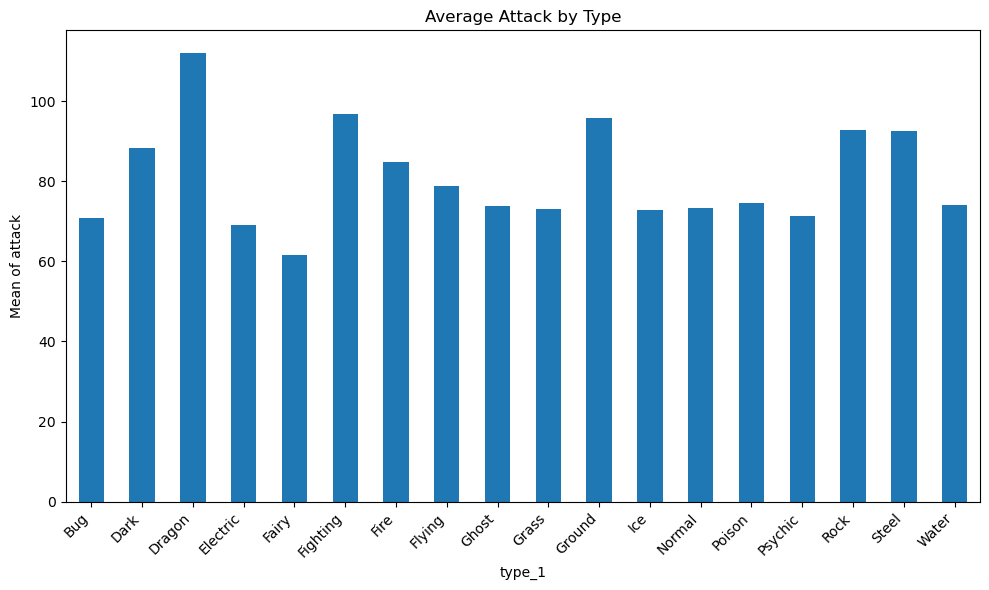

✓ Bar chart created: Mean of attack by type_1


In [22]:
# Test visualization tools
print("Testing visualization tools:\n")
print(create_bar_chart('type_1', 'attack', 'mean', 'Average Attack by Type'))

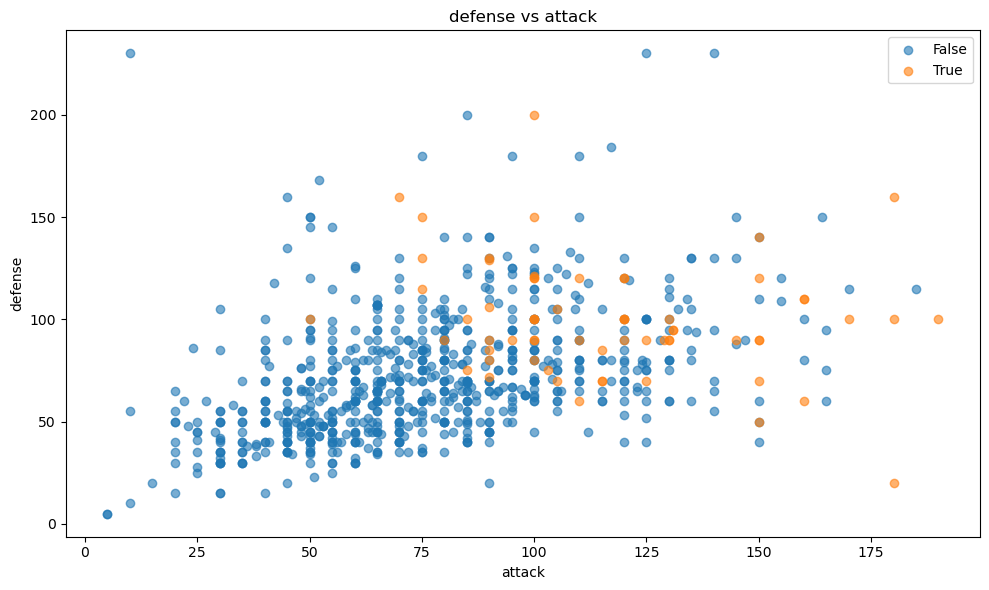

✓ Scatter plot created: defense vs attack


In [23]:
print(create_scatter_plot('attack', 'defense', color_by='legendary'))

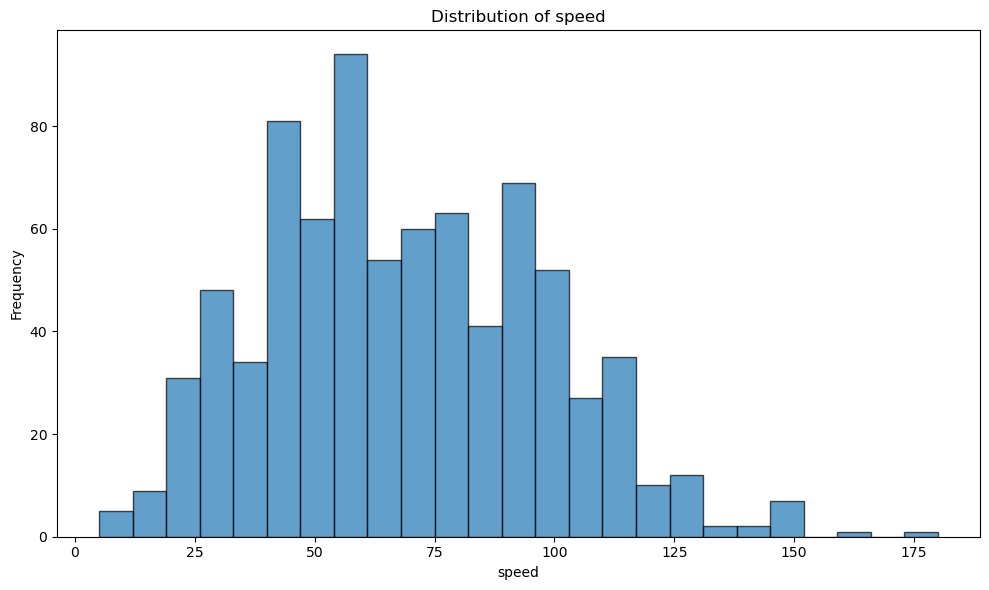

✓ Histogram created for speed


In [24]:
print(create_histogram('speed', bins=25))

### The Fundamental Limitation of Pre-Built Tools

Our visualization tools work great for simple queries:

✅ `create_bar_chart('type_1', 'attack', 'mean')` - "Show average attack by type"

But what about more complex queries?

**Query:** "Show me a bar chart of average attack for Fire-type Pokemon only"

**Problem:**
1. We need to **filter** first (`type_1 == 'Fire'`)
2. Then **visualize** the filtered data
3. But our tools can't pass dataframes between calls!

**Why not?**
- Each tool operates on the global `df`
- Tools return **strings** (for LLM to read)
- We can't chain: `filter_rows(...) → create_bar_chart(...)`

---

#### Possible Workarounds

**Attempt 1: Add filter parameters to viz tools**
```python
def create_bar_chart(x_col, y_col, filter_col=None, filter_value=None, ...):
    # What about multiple filters?
    # What about numeric filters like "attack > 100"?
    # What about "OR" conditions?
    # Parameter explosion! 💥
```

**Attempt 2: Create combo tools**
```python
def create_filtered_bar_chart(filter_condition, x_col, y_col, ...):
    # Now we need: create_filtered_scatter_plot, create_filtered_histogram...
    # And create_double_filtered_bar_chart for multiple conditions?
    # Not scalable! 💥
```

**Attempt 3: Use global filtered df**
```python
filtered_df = None

def set_filter(condition):
    global filtered_df
    filtered_df = df.query(condition)

def create_bar_chart(x_col, y_col):
    # Use filtered_df if it exists
    # But what if user wants two different filters?
    # State management nightmare! 💥
```

---

#### The Core Issue

**Pre-built tools can't compose.** We can't chain operations because:
- Tools don't pass dataframes to each other
- We'd need infinite parameter combinations to handle all scenarios
- Adding "flexibility" makes tools too complex (remember Design A?)

**What we really want:**
```python
# Filter first
fire_pokemon = df[df['type_1'] == 'Fire']

# Then visualize
fire_pokemon.groupby('type_1')['attack'].mean().plot(kind='bar')
```

This is **code** - operations flow naturally, variables connect steps.

---

#### The Solution: Code Generation

**Next Workshop:** Instead of pre-built tools, we'll teach the agent to **generate pandas code directly**.

**The agent will write:**
```python
fire_pokemon = df[df['type_1'] == 'Fire']
avg_attack = fire_pokemon.groupby('type_1')['attack'].mean()
plt.bar(avg_attack.index, avg_attack.values)
plt.title('Average Attack for Fire-type Pokemon')
plt.show()
```

**Why this solves the problem:**
-  Provides infinite composability (variables connect operations)
-  No parameter explosion (write exactly what's needed)
-  Natural pandas workflow (how data scientists actually work)
-  Handles any query complexity (the agent just writes more code)

**The tradeoff:** Code generation requires more careful safety (what if LLM writes malicious code?). We'll cover that next workshop.

---

**Key Insight:** Pre-built tools are great for simple, independent operations. But for complex workflows, **code generation approaches unlock much more capability**.

In [26]:
import inspect
from typing import Callable, List

# All tools in one place
all_tools = [
    load_csv, show_info, show_data,
    filter_rows, calculate_statistics, aggregate_by,
    create_bar_chart, create_scatter_plot, create_histogram
]


def generate_tool_descriptions(tools: List[Callable]) -> str:
    """Generate OpenAI-compatible tool descriptions from function introspection.
    
    Args:
        tools: List of functions to convert to tool descriptions
        
    Returns:
        Formatted string with tool descriptions for LLM prompt
    """
    descriptions = []
    
    for func in tools:
        # Get function signature
        sig = inspect.signature(func)
        params = []
        
        # Extract parameter info
        for name, param in sig.parameters.items():
            # Get type annotation if available
            param_type = param.annotation.__name__ if param.annotation != inspect.Parameter.empty else "any"
            # Get default value if available
            default = f" (default: {param.default})" if param.default != inspect.Parameter.empty else ""
            params.append(f"  - {name}: {param_type}{default}")
        
        # Get first line of docstring as description
        doc_lines = (func.__doc__ or "No description").strip().split('\n')
        short_desc = doc_lines[0]
        
        # Build description
        desc = f"""{func.__name__}: {short_desc}
Parameters:
{chr(10).join(params) if params else '  None'}
""".strip()
        
        descriptions.append(desc)
    
    return "\n\n".join(descriptions)


# Create tools dictionary for execution
tools_dict = {func.__name__: func for func in all_tools}

print("="*60)
print("Tool Description Generator")
print("="*60)
print("\nGenerated tool descriptions:\n")
print(generate_tool_descriptions(all_tools))

Tool Description Generator

Generated tool descriptions:

load_csv: Load CSV file into global dataframe.
Parameters:
  - filepath: str

show_info: Show dataframe structure: columns, types, missing values.
Parameters:
  None

show_data: Show first n rows of dataframe, optionally sorted.
Parameters:
  - n: int (default: 5)
  - sort_by: str (default: None)
  - ascending: bool (default: True)

filter_rows: Filter dataframe rows using pandas query syntax.
Parameters:
  - condition: str

calculate_statistics: Calculate statistics on a column.
Parameters:
  - column: str
  - stat_type: str

aggregate_by: Group data and calculate aggregate statistics.
Parameters:
  - group_by: str
  - agg_col: str
  - agg_func: str

create_bar_chart: Create a bar chart comparing categories.
Parameters:
  - category_col: str
  - value_col: str (default: None)
  - aggregation: str (default: count)
  - title: str (default: None)

create_scatter_plot: Create a scatter plot to show relationships between two numeric

---

## Part 3: Building the Agent

Now we'll create an agent that:
1. Reads user queries
2. Chooses the appropriate tool
3. Generates correct parameters
4. Executes and returns results

In [31]:
# Create tool registry

all_tools = [
    load_csv, show_info, show_data,
    filter_rows, calculate_statistics, aggregate_by,
    create_bar_chart, create_scatter_plot, create_histogram
]
tools = { t.__name__: t for t in all_tools }


def generate_tool_descriptions(tools: List[Callable]) -> str:
    """Generate OpenAI-compatible tool descriptions from function introspection.
    
    Args:
        tools: List of functions to convert to tool descriptions
        
    Returns:
        Formatted string with tool descriptions for LLM prompt
    """
    descriptions = []
    
    for func in tools:
        # Get function signature
        sig = inspect.signature(func)
        params = []
        
        # Extract parameter info
        for name, param in sig.parameters.items():
            # Get type annotation if available
            param_type = param.annotation.__name__ if param.annotation != inspect.Parameter.empty else "any"
            # Get default value if available
            default = f" (default: {param.default})" if param.default != inspect.Parameter.empty else ""
            params.append(f"  - {name}: {param_type}{default}")
        
        # Get first line of docstring as description
        doc_lines = (func.__doc__ or "No description").strip().split('\n')
        short_desc = doc_lines[0]
        
        # Build description
        desc = f"""{func.__name__}: {short_desc}
Parameters:
{chr(10).join(params) if params else '  None'}
""".strip()
        
        descriptions.append(desc)
    
    return "\n\n".join(descriptions)


print("Available tools:")
print(generate_tool_descriptions(all_tools))

Available tools:
load_csv: Load CSV file into global dataframe.
Parameters:
  - filepath: str

show_info: Show dataframe structure: columns, types, missing values.
Parameters:
  None

show_data: Show first n rows of dataframe, optionally sorted.
Parameters:
  - n: int (default: 5)
  - sort_by: str (default: None)
  - ascending: bool (default: True)

filter_rows: Filter dataframe rows using pandas query syntax.
Parameters:
  - condition: str

calculate_statistics: Calculate statistics on a column.
Parameters:
  - column: str
  - stat_type: str

aggregate_by: Group data and calculate aggregate statistics.
Parameters:
  - group_by: str
  - agg_col: str
  - agg_func: str

create_bar_chart: Create a bar chart comparing categories.
Parameters:
  - category_col: str
  - value_col: str (default: None)
  - aggregation: str (default: count)
  - title: str (default: None)

create_scatter_plot: Create a scatter plot to show relationships between two numerical columns.
Parameters:
  - x_col: str
  

In [32]:
def analytics_agent(query: str):
    """Simple agent that uses LLM to choose and call tools.
    
    Args:
        query: User's natural language question
        
    Returns:
        Result from tool execution
    """
    # Build prompt
    prompt = f"""You are a data analysis assistant.

Dataset: Pokemon with {len(df)} rows
Columns: {df.columns.tolist()}

Available tools:
{get_tool_descriptions()}

User query: "{query}"

Instructions:
- Choose the ONE tool that best answers this query
- Provide the exact parameters needed
- Respond with ONLY the tool call, no explanation

Format: tool_name(param1="value", param2="value")

Examples:
- Query: "show the data" → show_data(n=10)
- Query: "fire types" → filter_rows(condition="type1 == 'Fire'")
- Query: "average attack" → calculate_statistics(column="attack", stat_type="mean")

Your response:"""

    # Get LLM response
    response = generate(prompt).strip()
    print(f"🤖 Agent chose: {response}\n")
    
    # Execute tool
    try:
        result = eval(response, {"__builtins__": {}}, tools)
        return result
    except Exception as e:
        return f"Error executing tool: {str(e)}\nLLM response was: {response}"

### Test the Agent

In [33]:
# Test with various queries
test_queries = [
    "Show me the first 5 Pokemon",
    "Show me all Fire type Pokemon",
    "What's the average attack of all Pokemon?",
    "Show me average HP by type",
]

print("="*60)
print("TESTING AGENT")
print("="*60 + "\n")

for query in test_queries:
    print(f"Query: {query}")
    result = analytics_agent(query)
    print(result)
    print("\n" + "-"*60 + "\n")

TESTING AGENT

Query: Show me the first 5 Pokemon
🤖 Agent chose: show_data(n=5)

   #                   name type_1  type_2  total  hp  attack  defense  sp_atk  sp_def  speed  generation  legendary
0  1              Bulbasaur  Grass  Poison    318  45      49       49      65      65     45           1      False
1  2                Ivysaur  Grass  Poison    405  60      62       63      80      80     60           1      False
2  3               Venusaur  Grass  Poison    525  80      82       83     100     100     80           1      False
3  3  VenusaurMega Venusaur  Grass  Poison    625  80     100      123     122     120     80           1      False
4  4             Charmander   Fire     NaN    309  39      52       43      60      50     65           1      False

------------------------------------------------------------

Query: Show me all Fire type Pokemon
🤖 Agent chose: filter_rows(condition="type_1 == 'Fire'")

Found 52 Pokemon:
       #                       name type_

---

## What We Built Today

### 1. ✅ Design Thinking Process
- Started with user scenarios  
- Extracted core capabilities
- Designed composable tools
- **Discovered** why granularity matters through live experimentation

### 2. ✅ Tool Granularity Principle (Discovery-Based Learning)
- Tested 3 designs (too broad, too specific, just right)
- Experienced failures and successes firsthand
- Learned composability through practice

### 3. ✅ Nine Well-Designed Tools
- **Exploration**: `load_csv`, `show_info`, `show_data`
- **Analysis**: `filter_rows`, `calculate_statistics`, `aggregate_by`
- **Visualization**: `create_bar_chart`, `create_scatter_plot`, `create_histogram`

### 4. ✅ Discovered the Fundamental Limitation
- Pre-built tools can't chain operations
- Hitting the boundary between tools and code generation
- Understanding when to switch paradigms

### 5. ✅ Reusable modules
- `generate_tool_descriptions()`: Auto-generate docs via introspection

**Next Workshop:** We'll dive deep into the ReAct loop and build multi-step agents that can break down complex queries! Then we'll improve upon the existing agent we built today, to add code generation capabilities.